# CSIS3400 Project 01

- Shogo Tsuneto (300407262)

## References

- [Installing Jupyter](https://jupyter.org/install)
- [Pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
- [sklearn TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [sklearn MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)
- [sklearn KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [sklearn AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)
- [sklearn SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [sklearn metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html)
- [sklearn PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [sklearn TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
- [sklearn rbf parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)
- [gensim Keyedvectors.py](https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py)
- [Stack Overflow: How to get feature Importance in naive bayes?](https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes)
- Class Material:
  - Lab 3 – Text Representation
  - Lab 5 – Text Classification

## Planning

### Crude observations around the dataset

- the data has 3 columns: Row number, Text and Label
- Row numbers seem to be arbitrary because both `climate_train.csv` and `climate_test.csv` start from 0.  
- The label is already encoded as number  

### Plan

We are going to take steps to process the dataset.

- load train and test data as dataframes (first column as index)
- explore data and show basic information about the data
- cleaning data
  - label encoding
  - remove stop words and digits from the text (the task will be defined in a cleaner function)
- vectorize the text using sklearn.TfidfVectorizer
  - specify appropriate stop_words
  - specify appropriate token_pattern for excluding digits
- Build a Basic Model and Evaluate it
  - Build a Naive Bayes model using the train data
  - Evaluate the model using the test data
  - Show impactful features

## Basic Model

### Library Import and Data Loading

In [1]:
# Library Import
import numpy as np
import pandas as pd
import string
import itertools
import matplotlib.pyplot as plt
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from gensim.models import Word2Vec, KeyedVectors
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stsuneto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Data Loading

train = pd.read_csv('./climate_data/climate_train.csv', index_col=0)
test = pd.read_csv('./climate_data/climate_test.csv', index_col=0)

In [3]:
# Data Exploration

doc_sizes = [len(t.split()) for t in train['text']]

print(f"shape: {train.shape}")
print()
print(train.info())
print()
print("head(5)")
print(train.head(5))
print()
print(f"train dataset value counts: {train['label'].value_counts()}")
print(f"test dataset value counts: {test['label'].value_counts()}")
print()
print("basic statistics around doc sizes (using simple split() for counting the size)")
print(f"min: {np.min(doc_sizes)}")
print(f"MAX: {np.max(doc_sizes)}")
print(f"mean: {np.mean(doc_sizes)}")
print(f"std: {np.std(doc_sizes)}")
print(f"median: {np.median(doc_sizes)}")

shape: (1000, 2)

<class 'pandas.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   text    1000 non-null   str  
 1   label   1000 non-null   int64
dtypes: int64(1), str(1)
memory usage: 15.8 KB
None

head(5)
                                                text  label
0  − Scope 3: Optional scope that includes indire...      0
1  The Group is not aware of any noise pollution ...      0
2  Global climate change could exacerbate certain...      0
3  Setting an investment horizon is part and parc...      1
4  Climate change the physical impacts of climate...      0

train dataset value counts: label
0    575
1    425
Name: count, dtype: int64
test dataset value counts: label
0    222
1     98
Name: count, dtype: int64

basic statistics around doc sizes (using simple split() for counting the size)
min: 16
MAX: 452
mean: 72.224
std: 40.06487019821729
median: 63.0


In [4]:
# Based on the observations from the data exploration
# label is already encoded as 0/1

# The next step is to define clean() function that removes digits and stop words
stopwords = _stop_words.ENGLISH_STOP_WORDS

def clean(doc):
    doc = doc.lower()

    # Remove HTML line breaks
    doc = doc.replace("</br>", " ")
    
    # Remove punctuation and numbers
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    
    # Remove stopwords and tokenize
    # also lower the token
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    return doc

### Model Building

In [5]:
vectorizer = TfidfVectorizer(preprocessor=clean)

X_train = vectorizer.fit_transform(train['text'])
y_train = train['label']
X_test = vectorizer.transform(test['text']) # we don't fit to the test data (avoiding data leakage)
y_test = test['label']

print(f"size of vocabulary: {len(vectorizer.vocabulary_)}")
print(f"type of X: {type(X_train)}")
print(f"type of y: {type(y_train)}")
print(f"shape of X_train: {X_train.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_test: {y_test.shape}")

size of vocabulary: 6270
type of X: <class 'scipy.sparse._csr.csr_matrix'>
type of y: <class 'pandas.Series'>
shape of X_train: (1000, 6270)
shape of y_train: (1000,)
shape of X_test: (320, 6270)
shape of y_test: (320,)


In [6]:
# train NB model

nb = MultinomialNB()
%time nb.fit(X_train, y_train)

y_pred_nb = nb.predict(X_test)

CPU times: user 1.08 ms, sys: 663 μs, total: 1.75 ms
Wall time: 1.22 ms


### Testing and Evaluation

In [7]:
print(f"accuracy: {accuracy_score(y_test, y_pred_nb)}\n")
print(f"ROC_AUC: {roc_auc_score(y_test, y_pred_nb)}\n")
print(f"classification report: \n{classification_report(y_test, y_pred_nb)}")

accuracy: 0.79375

ROC_AUC: 0.7288104430961573

classification report: 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       222
           1       0.71      0.56      0.62        98

    accuracy                           0.79       320
   macro avg       0.76      0.73      0.74       320
weighted avg       0.79      0.79      0.79       320



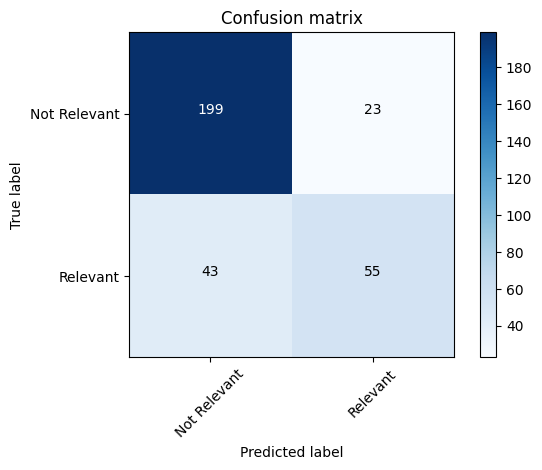

In [8]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plotting
conf_mat = confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(conf_mat, classes=['Not Relevant', 'Relevant'])
plt.show()

### Post Analysis

Impactful features.  
Naive Bayes calculate and store probability each feature contributes to a class.   
We can extract them and use as metrics that shows feature importances.  

In [9]:
print(f"class labels: {nb.classes_}")
print(f"probs: {nb.feature_log_prob_}")

class labels: [0 1]
probs: [[-8.91031337 -9.13350736 -9.02397953 ... -8.91183064 -8.87691659
  -9.01566029]
 [-9.05832551 -8.85647733 -8.88266606 ... -9.05832551 -8.92355584
  -9.05832551]]


In [10]:
# Top important words based on Naive Bayes

# Source - https://stackoverflow.com/a/62175164
# Posted by Tom, modified by community. See post 'Timeline' for change history
# Retrieved 2026-02-07, License - CC BY-SA 4.0
# and modified to fit our problem

# remember normalize=True outputs proportion 
prob_neg, prob_pos = y_train.value_counts(normalize=True)

df_nbf = pd.DataFrame()
df_nbf.index = vectorizer.get_feature_names_out()
# Convert log probabilities to probabilities. 
df_nbf['pos'] = np.e**(nb.feature_log_prob_[1, :]) # second class is 1
df_nbf['neg'] = np.e**(nb.feature_log_prob_[0, :])

df_nbf['odds_positive'] = (df_nbf['pos']/df_nbf['neg'])*(prob_pos/prob_neg)
df_nbf['odds_negative'] = (df_nbf['neg']/df_nbf['pos'])*(prob_neg/prob_pos )

# Here are the top5 most important words of your positive class:
odds_pos_top5 = df_nbf.sort_values('odds_positive',ascending=False)['odds_positive'][:5]
# Here are the top5 most important words of your negative class:
odds_neg_top5 = df_nbf.sort_values('odds_negative',ascending=False)['odds_negative'][:5]

print("top 5")
print(odds_pos_top5)
print()
print(odds_neg_top5)

top 5
million      5.064338
solar        4.798697
committed    4.523718
green        3.807755
ifc          3.682124
Name: odds_positive, dtype: float64

physical    13.703652
risks       10.795279
weather     10.547394
extreme      9.213923
events       9.132988
Name: odds_negative, dtype: float64


## Other Models

### Logistic Regression

In [11]:
logreg = LogisticRegression()
%time logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

# Evaluate
print("LogReg Accuracy: ", accuracy_score(y_test, y_pred_logreg))
print("LogReg ROC_AUC: ", roc_auc_score(y_test, y_pred_logreg))
print("LogReg classification report: \n", classification_report(y_test, y_pred_logreg))

CPU times: user 3.47 ms, sys: 707 μs, total: 4.17 ms
Wall time: 3.74 ms
LogReg Accuracy:  0.796875
LogReg ROC_AUC:  0.7424618496047066
LogReg classification report: 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       222
           1       0.69      0.60      0.64        98

    accuracy                           0.80       320
   macro avg       0.76      0.74      0.75       320
weighted avg       0.79      0.80      0.79       320



### Linear SVM

In [12]:
svm = LinearSVC()
%time svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

# Evaluate
print("SVM Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("SVM ROC_AUC: ", roc_auc_score(y_test, y_pred_svm))
print("SVM classification report: \n", classification_report(y_test, y_pred_svm))

CPU times: user 2.55 ms, sys: 513 μs, total: 3.06 ms
Wall time: 2.62 ms
SVM Accuracy:  0.76875
SVM ROC_AUC:  0.7307409450266593
SVM classification report: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.83       222
           1       0.62      0.63      0.63        98

    accuracy                           0.77       320
   macro avg       0.73      0.73      0.73       320
weighted avg       0.77      0.77      0.77       320



### KNN

In [13]:
knn = KNeighborsClassifier()
%time knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

# Evaluate
print("KNN Accuracy: ", accuracy_score(y_test, y_pred_knn))
print("KNN ROC_AUC: ", roc_auc_score(y_test, y_pred_knn))
print("KNN classification report: \n", classification_report(y_test, y_pred_knn))

CPU times: user 462 μs, sys: 388 μs, total: 850 μs
Wall time: 506 μs
KNN Accuracy:  0.7125
KNN ROC_AUC:  0.6902004044861189
KNN classification report: 
               precision    recall  f1-score   support

           0       0.82      0.75      0.78       222
           1       0.53      0.63      0.57        98

    accuracy                           0.71       320
   macro avg       0.67      0.69      0.68       320
weighted avg       0.73      0.71      0.72       320



### Comparison

**Logistic Regression** was the best performer.

It was the winner in accuracy, ROC AUC, and averaged f1 scores (both macro and weighted).
Naïve Bayes also performed well in accuracy, but it's recall for class 1 was the worst among all the models, and that resulted in slightly worse ROC_AUC.  

On the other hand, Linear SVC and KNN performed well in recall for class 1, at the cost of accuracy. It means they overpredicted the minority class.
Logistic Regression was the clear winner.

## Feature generation comparison using Logistic Regression

### Bag of Words (CountVectorizer)

In [14]:
count_vect = CountVectorizer(preprocessor=clean)
X_train_bow = count_vect.fit_transform(train['text'])
X_test_bow = count_vect.transform(test['text'])

lr_bow = LogisticRegression()
%time lr_bow.fit(X_train_bow, y_train)

y_pred_lr_bow = lr_bow.predict(X_test_bow)

# Evaluate
print("Logistic Regression Accuracy for BoW: ", accuracy_score(y_test, y_pred_lr_bow))
print("Logistic Regression ROC_AUC for BoW: ", roc_auc_score(y_test, y_pred_lr_bow))
print("Logistic Regression classification report for BoW: \n", classification_report(y_test, y_pred_lr_bow))

CPU times: user 11.2 ms, sys: 345 μs, total: 11.5 ms
Wall time: 11.5 ms
Logistic Regression Accuracy for BoW:  0.75
Logistic Regression ROC_AUC for BoW:  0.7029784886927745
Logistic Regression classification report for BoW: 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       222
           1       0.59      0.58      0.59        98

    accuracy                           0.75       320
   macro avg       0.71      0.70      0.70       320
weighted avg       0.75      0.75      0.75       320



### Pre-trained word embedding

In [15]:
# Load pretrained w2v model

pretrainedpath = "./model/GoogleNews-vectors-negative300.bin"
w2v_model = KeyedVectors.load_word2vec_format(pretrainedpath, binary=True)

print("Vocabulary size:", len(w2v_model.key_to_index))
print("Vector size:", w2v_model.vector_size)

Vocabulary size: 3000000
Vector size: 300


In [16]:
# take average of the embeddings of the all words in the document

def text2vec(text, model):
    # assume the text is already cleaned
    words = text.split()
    vec_sum = np.zeros(model.vector_size)
    count = 0
    for word in words:
        word = word.lower() # lower it just in case (although it must be lowered in "clean")
        if word in model:
            count += 1
            vec_sum = vec_sum + model[word] # ndarray
    return vec_sum / count

In [17]:
X_train_w2v = [text2vec(clean(text), w2v_model) for text in train['text']]
X_test_w2v = [text2vec(clean(text), w2v_model) for text in test['text']]

lr_w2v = LogisticRegression()
%time lr_w2v.fit(X_train_w2v, y_train)

y_pred_lr_w2v = lr_w2v.predict(X_test_w2v)

# Evaluate
print("Logistic Regression Accuracy for w2v: ", accuracy_score(y_test, y_pred_lr_w2v))
print("Logistic Regression ROC_AUC for w2v: ", roc_auc_score(y_test, y_pred_lr_w2v))
print("Logistic Regression classification report for w2v: \n", classification_report(y_test, y_pred_lr_w2v))

CPU times: user 2.61 ms, sys: 847 μs, total: 3.45 ms
Wall time: 2.75 ms
Logistic Regression Accuracy for w2v:  0.8
Logistic Regression ROC_AUC for w2v:  0.7703621989336275
Logistic Regression classification report for w2v: 
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       222
           1       0.67      0.69      0.68        98

    accuracy                           0.80       320
   macro avg       0.76      0.77      0.77       320
weighted avg       0.80      0.80      0.80       320



### Comparison

We trained Logistic Regression models with TF-IDF, BoW, and pretrained word2vec models.  
Word2Vec recorded the best accuracy and ROC_AUC in spite of the significant difference in the number of features (300 vs. 7322).  
Also, it is worth noting that Word2Vec has the highest recall for class 1.

- TF-IDF
  - accuracy: 0.796875
  - ROC_AUC:  0.7424618496047066
  - macro avg of f1 scores: 0.75
  - weighted avg of f1 scores: 0.79
  - recall for class 1: 0.60
- Bag of Words
  - accuracy: 0.75
  - ROC_AUC:  0.7029784886927745
  - macro avg of f1 scores: 0.70
  - weighted avg of f1 scores: 0.75
  - recall for class 1: 0.58
- Word2Vec
  - accuracy: 0.8
  - ROC_AUC:  0.7703621989336275
  - macro avg of f1 scores: 0.77
  - weighted avg of f1 scores: 0.80
  - recall for class 1: 0.69


## Competition

Based on the above experiments, using Word2Vec with Logistic Regression generalize well.  
However, there is still things we can give a try, including other ML algorithms.  

We tried

- Take weighted average using IDF as weights (put importance on more specific terms)
  - --> worsend the result
- PCA
- Other techniques such as
  - SVC (non-linear)
  - DecisionTree
  - RandomForest
  - Boosting (AdaBoost)

And SVC (rbf) with 5-component PCA derived from average word2vec (300 dimentions)  
**Macro average f1 score was 0.79**


In [18]:
# using the doc vectors from w2v
# X_train_w2v = [text2vec(clean(text), w2v_model) for text in train['text']]
# X_test_w2v = [text2vec(clean(text), w2v_model) for text in test['text']]

pca = PCA(n_components=5, random_state=42)

X_train_w2v_pca = pca.fit_transform(X_train_w2v)
X_test_w2v_pca = pca.transform(X_test_w2v)

# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# gamma means how far a single example can influence, higher the closer
# C: trade-off between correct classification vs. margin 
svm_w2v_pca = SVC(kernel='rbf', gamma=6.0, C=1.0, random_state=42)

%time svm_w2v_pca.fit(X_train_w2v_pca, y_train)

y_pred_svm_w2v_pca = svm_w2v_pca.predict(X_test_w2v_pca)

# Evaluate
print("SVM (rbf) Accuracy for w2v pca: ", accuracy_score(y_test, y_pred_svm_w2v_pca))
print("SVM (rbf) ROC_AUC for w2v pca: ", roc_auc_score(y_test, y_pred_svm_w2v_pca))
print("SVM (rbf) classification report for w2v pca: \n", classification_report(y_test, y_pred_svm_w2v_pca))

CPU times: user 5.55 ms, sys: 151 μs, total: 5.7 ms
Wall time: 5.7 ms
SVM (rbf) Accuracy for w2v pca:  0.81875
SVM (rbf) ROC_AUC for w2v pca:  0.7895752895752897
SVM (rbf) classification report for w2v pca: 
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       222
           1       0.70      0.71      0.71        98

    accuracy                           0.82       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.82      0.82      0.82       320

